# CH 6: Automated Project: Planning, Estimation, and Allocation

In [1]:
!pip install -qU crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.237.0 requires protobuf<5.0,>=3.12, but you have protobuf 5.29.2 which is incompatible.


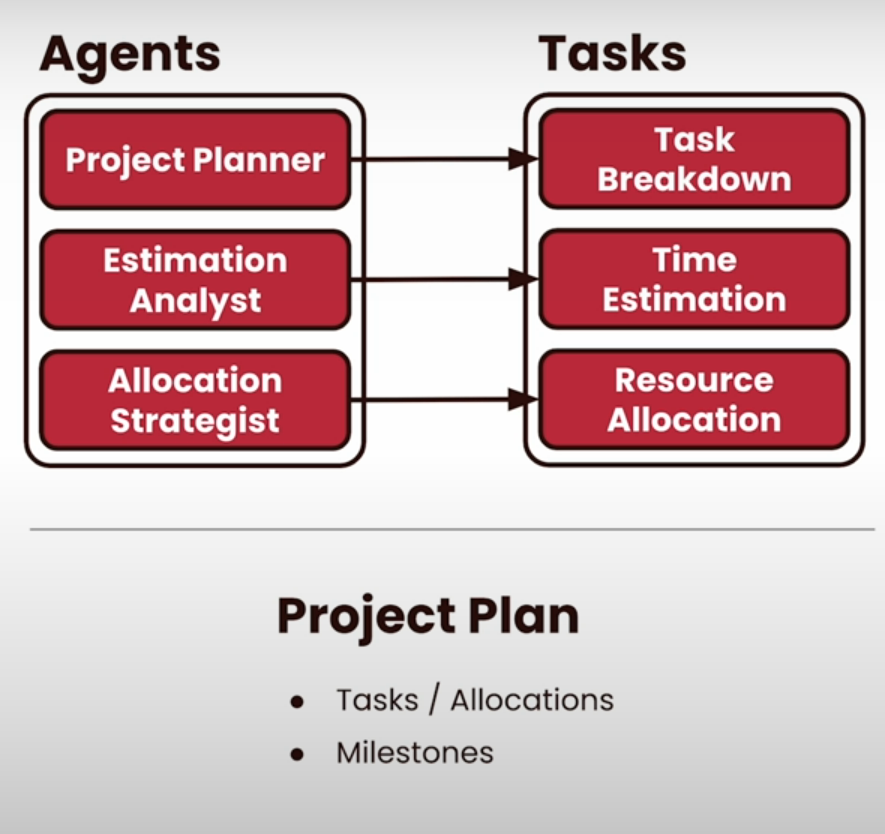

In [19]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [31]:
import os
import yaml
from utils import get_bedrock_client, get_haiku_config, get_sonnet_config
from langchain_community.chat_models import BedrockChat  # Changed this import
from crewai import Agent, Task, Crew

In [21]:
# import os
# from utils import get_openai_api_key

# openai_api_key = get_openai_api_key()
# os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'


bedrock_client = get_bedrock_client()
sonnet_config = get_sonnet_config()  # Using Sonnet config

# Create BedrockChat instance for CrewAI
llm = BedrockChat(
    client=bedrock_client,
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",  # Updated model ID
    streaming=True,
    model_kwargs={
        "temperature": sonnet_config["temperature"],
        "top_p": sonnet_config["top_p"],
        "max_tokens": sonnet_config["max_tokens"],
        "anthropic_version": "bedrock-2023-05-31"
    }
)

# Set model name in environment if needed
os.environ["MODEL_NAME"] = "anthropic.claude-3-sonnet-20240229-v1:0"

## Loading Tasks and Agents YAML files

In [22]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

## Create Pydantic Models for Structured Output

In [23]:
from typing import List
from pydantic import BaseModel, Field

class TaskEstimate(BaseModel):
    task_name: str = Field(..., description="Name of the task")
    estimated_time_hours: float = Field(..., description="Estimated time to complete the task in hours")
    required_resources: List[str] = Field(..., description="List of resources required to complete the task")

class Milestone(BaseModel):
    milestone_name: str = Field(..., description="Name of the milestone")
    tasks: List[str] = Field(..., description="List of task IDs associated with this milestone")

class ProjectPlan(BaseModel):
    tasks: List[TaskEstimate] = Field(..., description="List of tasks with their estimates")
    milestones: List[Milestone] = Field(..., description="List of project milestones")

## Create Crew, Agents and Tasks

In [25]:
# Creating Agents
project_planning_agent = Agent(
  config=agents_config['project_planning_agent'],
    llm=llm
)

estimation_agent = Agent(
  config=agents_config['estimation_agent'],
  llm=llm
)

resource_allocation_agent = Agent(
  config=agents_config['resource_allocation_agent'],
  llm=llm
)

# Creating Tasks
task_breakdown = Task(
  config=tasks_config['task_breakdown'],
  agent=project_planning_agent
)

time_resource_estimation = Task(
  config=tasks_config['time_resource_estimation'],
  agent=estimation_agent
)

resource_allocation = Task(
  config=tasks_config['resource_allocation'],
  agent=resource_allocation_agent,
  output_pydantic=ProjectPlan # This is the structured output we want
)

# Creating Crew
crew = Crew(
  agents=[
    project_planning_agent,
    estimation_agent,
    resource_allocation_agent
  ],
  tasks=[
    task_breakdown,
    time_resource_estimation,
    resource_allocation
  ],
  verbose=True
)

2025-01-03 04:21:49,167 - 140152004241216 - __init__.py-__init__:537 - WARNING: Overriding of current TracerProvider is not allowed


## Crew's Inputs

In [26]:
from IPython.display import display, Markdown

project = 'Website'
industry = 'Technology'
project_objectives = 'Create a website for a small business'
team_members = """
- John Doe (Project Manager)
- Jane Doe (Software Engineer)
- Bob Smith (Designer)
- Alice Johnson (QA Engineer)
- Tom Brown (QA Engineer)
"""
project_requirements = """
- Create a responsive design that works well on desktop and mobile devices
- Implement a modern, visually appealing user interface with a clean look
- Develop a user-friendly navigation system with intuitive menu structure
- Include an "About Us" page highlighting the company's history and values
- Design a "Services" page showcasing the business's offerings with descriptions
- Create a "Contact Us" page with a form and integrated map for communication
- Implement a blog section for sharing industry news and company updates
- Ensure fast loading times and optimize for search engines (SEO)
- Integrate social media links and sharing capabilities
- Include a testimonials section to showcase customer feedback and build trust
"""

# Format the dictionary as Markdown for a better display in Jupyter Lab
formatted_output = f"""
**Project Type:** {project}

**Project Objectives:** {project_objectives}

**Industry:** {industry}

**Team Members:**
{team_members}
**Project Requirements:**
{project_requirements}
"""
# Display the formatted output as Markdown
display(Markdown(formatted_output))


**Project Type:** Website

**Project Objectives:** Create a website for a small business

**Industry:** Technology

**Team Members:**

- John Doe (Project Manager)
- Jane Doe (Software Engineer)
- Bob Smith (Designer)
- Alice Johnson (QA Engineer)
- Tom Brown (QA Engineer)

**Project Requirements:**

- Create a responsive design that works well on desktop and mobile devices
- Implement a modern, visually appealing user interface with a clean look
- Develop a user-friendly navigation system with intuitive menu structure
- Include an "About Us" page highlighting the company's history and values
- Design a "Services" page showcasing the business's offerings with descriptions
- Create a "Contact Us" page with a form and integrated map for communication
- Implement a blog section for sharing industry news and company updates
- Ensure fast loading times and optimize for search engines (SEO)
- Integrate social media links and sharing capabilities
- Include a testimonials section to showcase customer feedback and build trust



## Kicking off the crew

In [27]:
# The given Python dictionary
inputs = {
  'project_type': project,
  'project_objectives': project_objectives,
  'industry': industry,
  'team_members': team_members,
  'project_requirements': project_requirements
}

# Run the crew
result = crew.kickoff(
  inputs=inputs
)

 [DEBUG]: == Working Agent: The Ultimate Project Planner

 [INFO]: == Starting Task: Carefully analyze the project_requirements for the Website project and break them down into individual tasks. Define each task's scope in detail, set achievable timelines, and ensure that all dependencies are accounted for:

- Create a responsive design that works well on desktop and mobile devices
- Implement a modern, visually appealing user interface with a clean look
- Develop a user-friendly navigation system with intuitive menu structure
- Include an "About Us" page highlighting the company's history and values
- Design a "Services" page showcasing the business's offerings with descriptions
- Create a "Contact Us" page with a form and integrated map for communication
- Implement a blog section for sharing industry news and company updates
- Ensure fast loading times and optimize for search engines (SEO)
- Integrate social media links and sharing capabilities
- Include a testimonials section to sh

## Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [32]:
import pandas as pd

costs = 0.150 * (crew.usage_metrics.prompt_tokens + crew.usage_metrics.completion_tokens) / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([crew.usage_metrics.dict()])
df_usage_metrics

AttributeError: 'dict' object has no attribute 'prompt_tokens'

## Result

In [33]:
result.pydantic.dict()

AttributeError: 'ProjectPlan' object has no attribute 'pydantic'

## Inspect further

In [34]:
tasks = result.pydantic.dict()['tasks']
df_tasks = pd.DataFrame(tasks)

# Display the DataFrame as an HTML table
df_tasks.style.set_table_attributes('border="1"').set_caption("Task Details").set_table_styles(
    [{'selector': 'th, td', 'props': [('font-size', '120%')]}]
)

AttributeError: 'ProjectPlan' object has no attribute 'pydantic'

### Inspecting Milestones

In [35]:
milestones = result.pydantic.dict()['milestones']
df_milestones = pd.DataFrame(milestones)

# Display the DataFrame as an HTML table
df_milestones.style.set_table_attributes('border="1"').set_caption("Task Details").set_table_styles(
    [{'selector': 'th, td', 'props': [('font-size', '120%')]}]
)

AttributeError: 'ProjectPlan' object has no attribute 'pydantic'